In [2]:
%matplotlib
import os.path
import configparser
import sqlite3
import socket
import matplotlib.pyplot as plt

from torch.utils.data import Dataset

config = configparser.ConfigParser()
config.read(os.path.join(os.pardir, 'config.ini'))

data_dir = config['directories']['data']

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
conn = sqlite3.connect(database=os.path.join(data_dir, 'birds.db'))
cursor = conn.cursor()

In [4]:
classes  = [(class_id, class_name)     for (class_id, class_name)     in cursor.execute("select class_id, class_name from classes").fetchall()]
concepts = [(concept_id, concept_name) for (concept_id, concept_name) in cursor.execute("select concept_id,concept_name from concepts").fetchall()]

In [5]:
def concept_value_counts():
    cursor = conn.cursor()
    sql = ("""select d.concept_name,
                     i.trainset,
                     a.value,
                     count(a.value)
              from   images i, 
                     classes cc, 
                     image_attributes ia,
                     attributes a,
                     concepts d
              where i.class_id = cc.class_id 
              and   i.image_id = ia.image_id 
              and   a.attribute_id = ia.attribute_id
              and   d.concept_id   = a.concept_id
              and   ia.present = 1
              and   cc.class_id = 3
              group by 
                     i.trainset,
                     cc.class_name,
                     d.concept_name,
                     a.value
              order by
                     d.concept_name,
                     cc.class_name,
                     i.trainset
                     """)
    cursor.execute(sql)
    records = cursor.fetchall()
    cursor.close()
    return records
records = concept_value_counts()

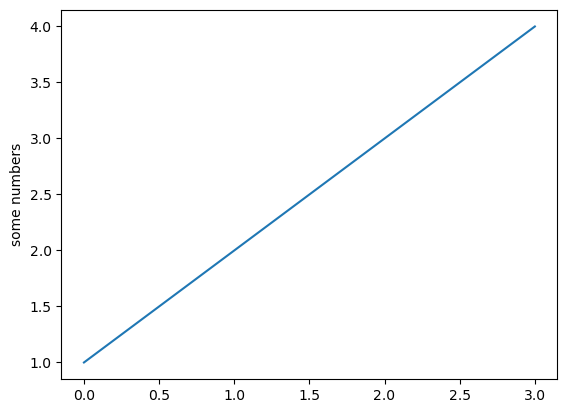

In [6]:
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

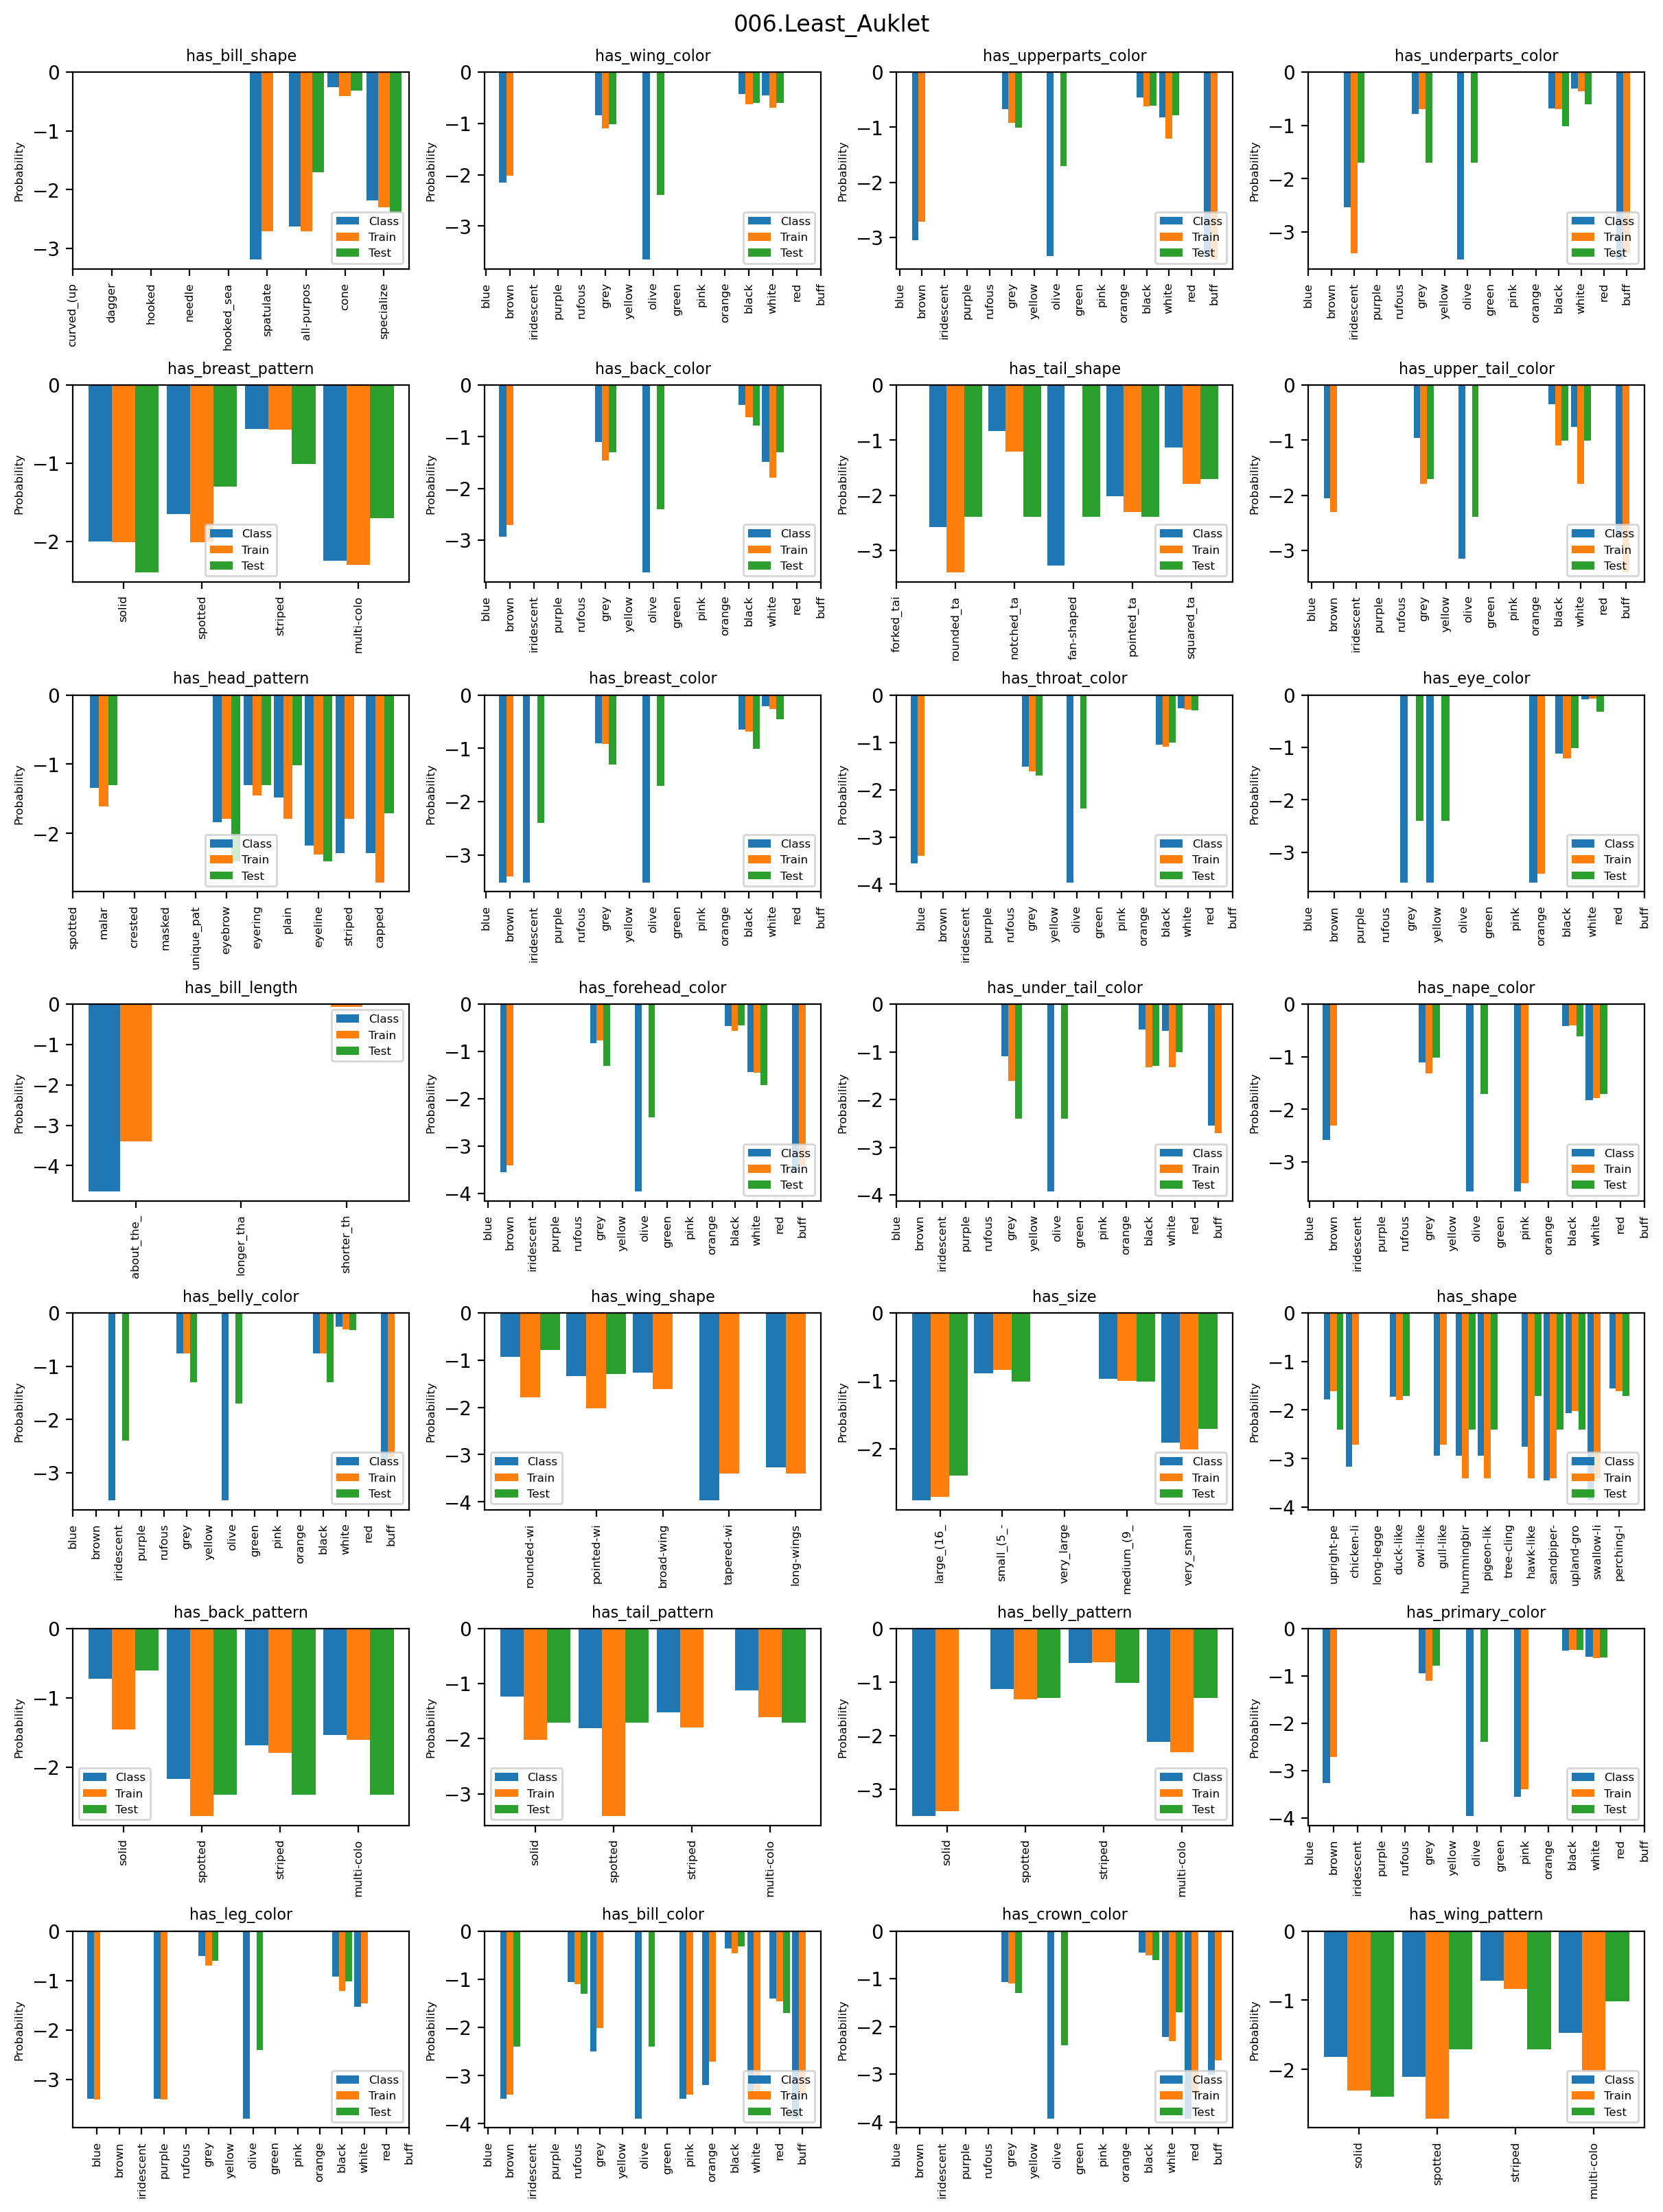

In [7]:
rows, cols = 7,4
class_id = 6

fig, ax = plt.subplots(nrows=rows, ncols=cols, layout='constrained', dpi=200, figsize=(12,16))
fig.suptitle([name for (id, name) in classes if id == class_id][0])
for row in range(rows):
    for col in range(cols):
        concept_id = 1 + (row * cols)  + col
        # Retreive the list of possible values for the concept.
        values    = [value for value in cursor.execute("select value_id, value from attributes where concept_id = ?", (concept_id,)).fetchall()]
        value_ids   = [value[0] for value in values]
        value_names = [value[1][:10] for value in values]
                
        class_probs = [record for record in 
                       cursor.execute("""select p.probability,
                                                p.naive_train_probability,
                                                p.naive_test_probability
                                     from   class_attribute_probabilities p,
                                            attributes a
                                     where  p.class_id = ?
                                     and    p.attribute_id = a.attribute_id
                                     and    a.concept_id = ?
                                     order by a.value_id
                                     """, (class_id, concept_id)).fetchall()]
        
        class_probs = [[probabilty[field] for probabilty in class_probs] for field in range(3)]
        
        width = 0.30  # the width of the bars
        multiplier = 0

        for dataset, probabilties in enumerate(class_probs):
            offset = width * multiplier
            bar_starts = [value_id + offset for value_id in value_ids]
            rects = ax[row][col].bar(bar_starts, probabilties, width)
            multiplier += 1
            
        tick_starts = [value_id + width for value_id in value_ids]
    
               
        ax[row][col].set_title([concept[1] for concept in concepts if concept[0] == concept_id][0],  fontsize=8)
        ax[row][col].set_ylabel('Probability', fontsize=6)
        ax[row][col].set_xticks(tick_starts, value_names, rotation=90, fontsize=6)
        ax[row][col].legend( ['Class', 'Train', 'Test'],  fontsize=6)

plt.savefig('class_' + str(class_id))


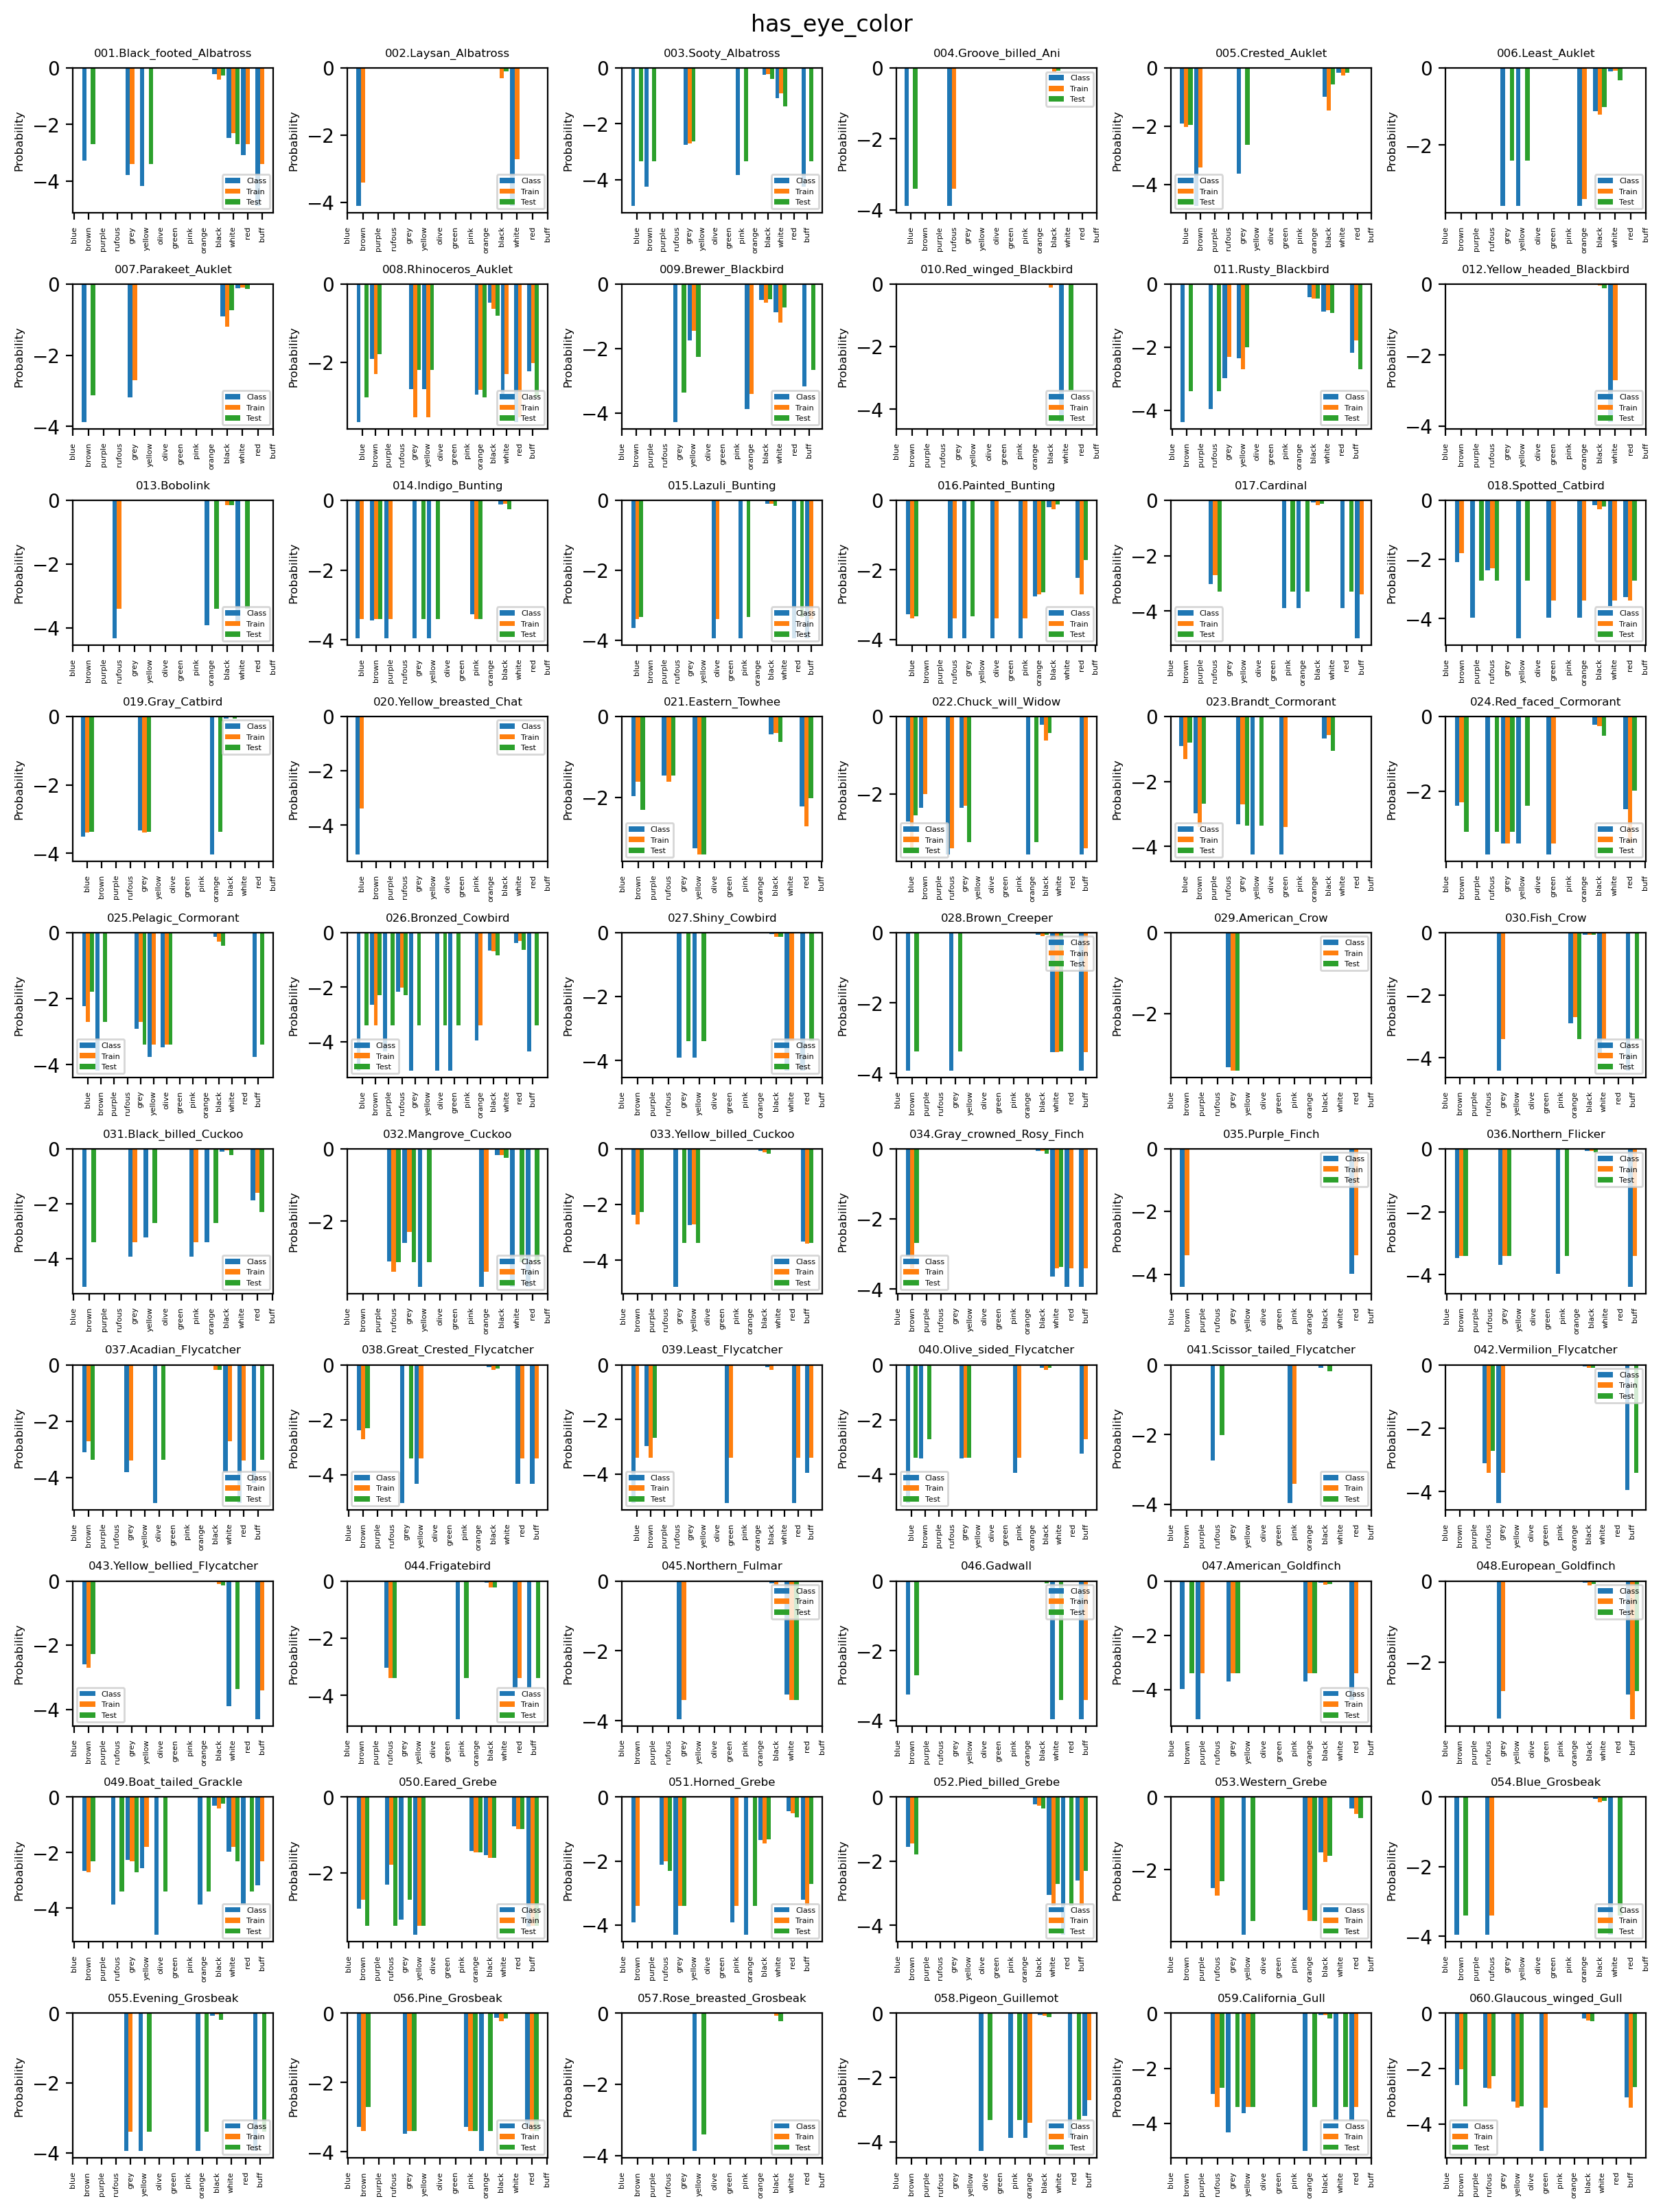

In [8]:
rows, cols = 10,6
concept_id = 12

fig, ax = plt.subplots(nrows=rows, ncols=cols, layout='constrained', dpi=200, figsize=(12,16))
fig.suptitle([name for (id, name) in concepts if id == concept_id][0])
for row in range(rows):
    for col in range(cols):
        class_id = 1 + (row * cols)  + col
        # Retreive the list of possible values for the concept.
        values    = [value for value in cursor.execute("select value_id, value from attributes where concept_id = ?", (concept_id,)).fetchall()]
        value_ids   = [value[0] for value in values]
        value_names = [value[1][:10] for value in values]
                
        class_probs = [record for record in 
                       cursor.execute("""select p.probability,
                                                p.naive_train_probability,
                                                p.naive_test_probability
                                     from   class_attribute_probabilities p,
                                            attributes a
                                     where  p.class_id = ?
                                     and    p.attribute_id = a.attribute_id
                                     and    a.concept_id = ?
                                     order by a.value_id
                                     """, (class_id, concept_id)).fetchall()]
        
        class_probs = [[probabilty[field] for probabilty in class_probs] for field in range(3)]
        
        width = 0.30  # the width of the bars
        multiplier = 0

        for dataset, probabilties in enumerate(class_probs):
            offset = width * multiplier
            bar_starts = [value_id + offset for value_id in value_ids]
            rects = ax[row][col].bar(bar_starts, probabilties, width)
            multiplier += 1
            
        tick_starts = [value_id + width for value_id in value_ids]
    
               
        ax[row][col].set_title([cls[1] for cls in classes if cls[0] == class_id][0],  fontsize=6)
        ax[row][col].set_ylabel('Probability', fontsize=6)
        ax[row][col].set_xticks(tick_starts, value_names, rotation=90, fontsize=4)
        ax[row][col].legend( ['Class', 'Train', 'Test'],  fontsize=4)

plt.savefig('concept_' + str(concept_id))


In [11]:
len(records)

302